In [1]:
%matplotlib inline
%load_ext cython
%load_ext autoreload

import matplotlib.pyplot as plt
import numpy as np
from plotting_utils import label_sample
import pandas as pd
import glob
import re
import os
from multiprocessing import Pool
import seaborn as sns
from matplotlib import rcParams
from sequencing_tools.viz_tools import color_encoder

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [2]:
%%cython
from collections import Counter, defaultdict
from operator import itemgetter
import re
from xopen import xopen

sc_re = re.compile('([0-9]+)S')
cdef soft_clip_base(cigar):
    s = sc_re.findall(cigar)
    s = map(int, s)
    return sum(s)

cpdef get_start(sample_folder):
    cdef:
        str line
        str chrom, start, end, strand, cigar
        list fields
    
    tRNA_regex = re.compile('^TR[A-Z]-')
    end_loc_counter = defaultdict(Counter)
    bed_file = sample_folder + '/count_temp/small_RNA.bed.gz'
    with xopen(bed_file) as bed:
        for line in bed:
            fields = line.strip().split('\t')
            chrom, start, end, strand, cigar = itemgetter(0,1,2,5, 6)(fields)
            if tRNA_regex.search(chrom) and strand == "+" and soft_clip_base(cigar) < 10:
                end_loc_counter[long(start)][long(end)] += 1
    return end_loc_counter

In [3]:
sample_folders = glob.glob('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/*001')
sample_folders = filter(lambda x: re.search('^[Qq][cC][fF][0-9]+|[qQ][cC][fF]_[pP]hos|[DE][ED]|Exo|[fF]rag', os.path.basename(x)), 
                     sample_folders) 
sample_folders = list(sample_folders)

In [4]:
p = Pool(24)
dfs = p.map(get_start, sample_folders)
p.close()
p.join()

In [5]:
df = []
for sample_folder, d in zip(sample_folders, dfs):
    for start, start_d in d.items():
        df.append(pd.DataFrame({'end_count': list(start_d.values()),
                             'end': list(start_d.keys())}) \
            .assign(sample = os.path.basename(sample_folder))\
            .assign(start = start))
    
    
ce = color_encoder()
df = pd.concat(df, sort=False) \
    .assign(prep = lambda d: d['sample'].map(label_sample)) \
    .assign(color = lambda d: ce.fit_transform(d.prep)) 
df.head()

,end_count,end,sample,start,prep,color
0,327911,74,Qcf_Phos2_R1_001,0,DNase I + Phosphatase,#009E73
1,41,45,Qcf_Phos2_R1_001,0,DNase I + Phosphatase,#009E73
2,130,55,Qcf_Phos2_R1_001,0,DNase I + Phosphatase,#009E73
3,1174,67,Qcf_Phos2_R1_001,0,DNase I + Phosphatase,#009E73
4,34488,72,Qcf_Phos2_R1_001,0,DNase I + Phosphatase,#009E73


In [6]:
end_df = df\
    .groupby(['prep','sample','end'], as_index=False)\
    .agg({'end_count':'sum'})\
    .assign(end_fraction = lambda d: d.groupby('sample').end_count.transform(lambda x: 100*x/x.sum()))\
    .sort_values('end') \
    .query('end < 70')
end_df.head()

,prep,sample,end,end_count,end_fraction
1229,DNase I + Phosphatase,Qcf_Phos3_R1_001,15,1,0.000037
1012,DNase I + Exo I,Qcf_Exo1_R1_001,15,1,0.000032
220,DNase I,Qcf11_R1_001,16,1,0.000014
1013,DNase I + Exo I,Qcf_Exo1_R1_001,16,2,0.000064
1230,DNase I + Phosphatase,Qcf_Phos3_R1_001,17,1,0.000037


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


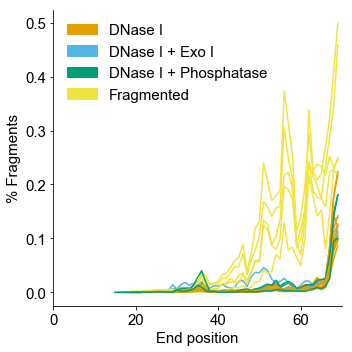

In [7]:
sample_df = df.filter(['sample','color']).drop_duplicates()
p = sns.FacetGrid(data = end_df, 
              hue = 'sample', 
              hue_order=sample_df['sample'].tolist(),
             palette = sample_df.color.tolist(),
            size = 5)
p.map(plt.plot, 'end', 'end_fraction')
ce.show_legend(p.fig.axes[0], fontsize=15, 
               loc = 'upper left',
              frameon=False)
p.set_axis_labels('End position', '% Fragments')
p.set(xlim=(0,70))

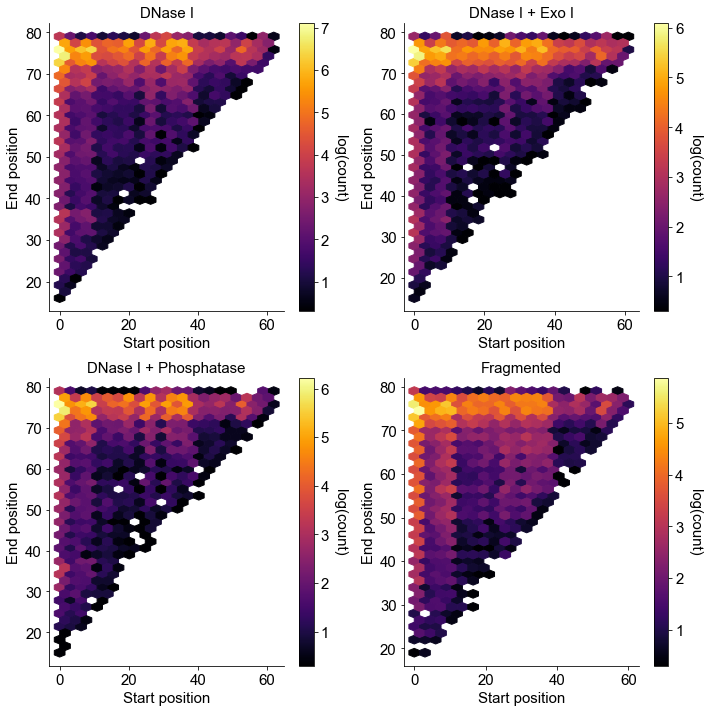

In [8]:
fig = plt.figure(figsize=(10,10))
for i, (prep, d) in enumerate(df.groupby('prep')):
    ax = fig.add_subplot(2,2,i+1)
    d = d \
        .query(' end < 80')\
        .groupby(['start','end'], as_index=False)\
        .agg({'end_count':'sum'}) 
    p = ax.hexbin(x = d['start'], y = d['end'], 
                  C = d['end_count'],
                  reduce_C_function=np.sum,
                  mincnt = 0, cmap ='inferno',
                 gridsize=(20,20), bins = 'log')
    cb = plt.colorbar(p)
    cb.set_label('log(count)',rotation = 270, va = 'bottom')
    ax.set_title(prep, size = 15)
    ax.set_xlabel('Start position')
    ax.set_ylabel('End position')
fig.tight_layout()
sns.despine()

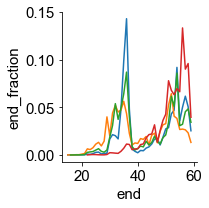

In [9]:
start0_df = df\
        .groupby(['color','prep','start','end'], as_index=False)\
        .agg({'end_count':'sum'}) \
        .query('start == 0 & end < 60 ')\
        .assign(end_fraction = lambda d: d.groupby('prep').end_count.transform(lambda x: x/x.sum()))
p = sns.FacetGrid( start0_df,
    hue = 'prep')
p.map(plt.plot, 'end', 'end_fraction')

In [10]:
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [13]:
alt.Chart(df\
        .groupby(['prep','start','end'],as_index=False)\
        .agg({'end_count':'sum'}))\
    .mark_rect()\
    .encode(
        x='start',
        y='end',
        color='end_count',
        column = 'prep'
)